In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
first_row_m = session.query(Measurement).first()
first_row_m.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7fbe0bb380f0>,
 'tobs': 65.0,
 'date': '2010-01-01',
 'id': 1,
 'prcp': 0.08,
 'station': 'USC00519397'}

In [11]:
first_row_s = session.query(Station).first()
first_row_s.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7fbe0bb38898>,
 'latitude': 21.2716,
 'station': 'USC00519397',
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1,
 'elevation': 3.0}

In [52]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
last_12mo_precip = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

last_data_point = last_12mo_precip[0]

# Calculate the date 1 year ago from the last data point in the database
year_from_last_data_point = dt.datetime.strptime(last_data_point, "%Y-%m-%d") - dt.timedelta(days = 365)

# Perform a query to retrieve the data and precipitation scores
data_precrip_scores = session.query(Measurement.date, Measurement.prcp). \
    filter(Measurement.date >= year_from_last_data_point).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
data_precrip_scores_df = pd.DataFrame(data_precrip_scores, columns = ['Date', 'Precipitation Score'])
data_precrip_scores_df = data_precrip_scores_df.dropna()

data_precrip_scores_df = data_precrip_scores_df.set_index('Date')

# Sort the dataframe by date
data_precrip_scores_df = data_precrip_scores_df.sort_values(by = 'Date')

data_precrip_scores_df = data_precrip_scores_df.groupby(data_precrip_scores_df.index).mean().round(2)

data_precrip_scores_df.head()

,Precipitation Score
Date,
2016-08-24,1.56
2016-08-25,0.08
2016-08-26,0.02
2016-08-27,0.06
2016-08-28,0.52


/Users/chloe/opt/anaconda3/envs/PythonData/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


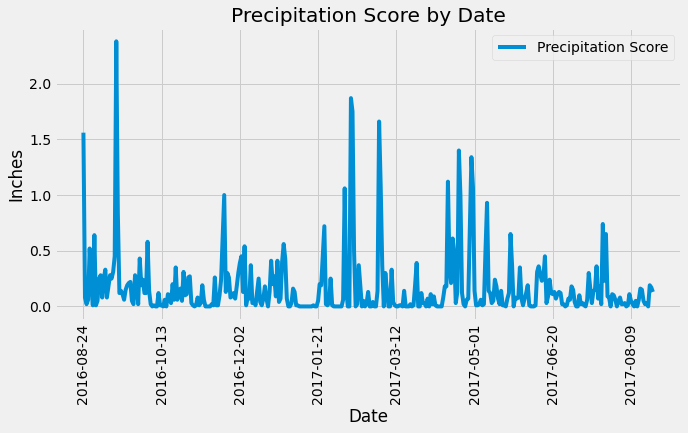

In [13]:
# Use Pandas Plotting with Matplotlib to plot the data
data_precrip_scores_df.plot(figsize = (10,5))
plt.xticks(rotation = 90)
plt.legend(loc = "upper right")
plt.ylabel("Inches")
plt.title("Precipitation Score by Date")
plt.savefig("Images/prcp_score_by_date")
plt.show()

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
data_precrip_scores_df.describe().round(2)

,Precipitation Score
count,365.00
mean,0.17
std,0.30
min,0.00
25%,0.01
50%,0.07
75%,0.19
max,2.38


In [15]:
# Design a query to show how many stations are available in this dataset?
number_stations = session.query(Station.station).distinct().count()
print(f"There are {number_stations} stations available in this dataset.")

There are 9 stations available in this dataset.


In [19]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
most_active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [20]:
most_active = most_active_stations[0][0]
print(f"Station {most_active} is has the greated number of observations.")

Station USC00519281 is has the greated number of observations.


In [36]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
recorded_temp = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), \
                                     func.avg(Measurement.tobs)).filter((Measurement.station) == most_active).all()

print(f"Data from the most active stations, {most_active}, shows that...")
print(f"The lowest temperature recorded is {recorded_temp[0][0]}\N{DEGREE SIGN}.")
print(f"The highest temperature recorded is {recorded_temp[0][1]}\N{DEGREE SIGN}.")
print(f"The average temperature is {round(recorded_temp[0][2], 2)}\N{DEGREE SIGN}.")

Data from the most active stations, USC00519281, shows that...
The lowest temperature recorded is 54.0°.
The highest temperature recorded is 85.0°.
The average temperature is 71.66°.


In [51]:
# Choose the station with the highest number of temperature observations.
highest_temp_obsv = session.query(Measurement.station, Measurement.tobs, func.count(Measurement.tobs)).\
    group_by(Measurement.tobs).order_by(func.count(Measurement.tobs).desc()).first()

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
highest_temp_obsv_station = highest_temp_obsv[0]

last_year_temp_obsv = session.query(Measurement.tobs). \
    filter(Measurement.date >= year_from_last_data_point).all()

last_year_temp_obsv_df = pd.DataFrame(last_year_temp_obsv, columns = ['Temperature Observation'])
last_year_temp_obsv_df.head()

,Temperature Observation
0,79.0
1,80.0
2,79.0
3,77.0
4,78.0


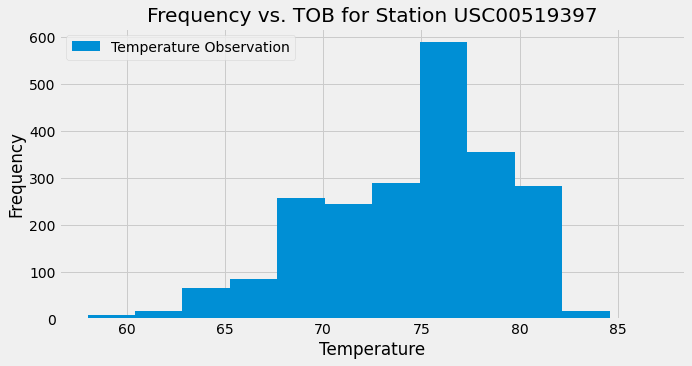

In [60]:
last_year_temp_obsv_df.plot.hist(bins = 12, figsize = (10,5))
plt.legend(loc = "upper left")
plt.xlabel("Temperature")
plt.title(f"Frequency vs. TOB for Station {highest_temp_obsv_station}")
plt.savefig("Images/tob_frequency")
plt.show()

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
